In [1]:
import os
import time
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Graph tools
import networkx as nx
from torch_geometric.data import Data

# Ensure clean output folders
os.makedirs("visualization", exist_ok=True)

# Load dataset
df = pd.read_csv("Data/borg_traces_data.csv")
print("✅ Dataset loaded:", df.shape)


✅ Dataset loaded: (405894, 34)


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load and prepare dataset
df = pd.read_csv("Data/borg_traces_data.csv")

# Use 'start_time' as the temporal column if 'time' is missing or zero
df['time'] = df['start_time']

# Define features
time_features = ['assigned_memory', 'page_cache_memory', 'priority', 'scheduling_class']
required_columns = time_features + ['failed', 'time', 'machine_id', 'alloc_collection_id']

# Check missing values
missing_report = df[required_columns].isnull().sum()
print("🔍 Missing values per column:\n", missing_report)

# Filter clean rows
df_clean = df[required_columns].dropna()
print(f"✅ Usable rows after cleaning: {len(df_clean)}")

# Only continue if we have enough data
if len(df_clean) < 1000:
    raise ValueError("🚫 Not enough usable rows after cleaning. Please inspect the dataset.")

# Normalize scalar features
scaler = StandardScaler()
df_clean[time_features] = scaler.fit_transform(df_clean[time_features])


🔍 Missing values per column:
 assigned_memory        0
page_cache_memory      0
priority               0
scheduling_class       0
failed                 0
time                   0
machine_id             0
alloc_collection_id    0
dtype: int64
✅ Usable rows after cleaning: 405894


In [3]:
import torch

# Parameters
SEQ_LEN = 6
features = ['assigned_memory', 'page_cache_memory', 'priority', 'scheduling_class']
group_col = 'machine_id'
label_col = 'failed'
time_col = 'time'

# Extract sequences per machine
sequences = []
labels = []
job_indices = []

df_clean = df_clean.sort_values(by=time_col)

for machine_id, group in df_clean.groupby(group_col):
    group = group.sort_values(by=time_col)
    feat_array = group[features].values
    label_array = group[label_col].values
    index_array = group.index.values

    if len(group) >= SEQ_LEN:
        for i in range(len(group) - SEQ_LEN + 1):
            chunk = feat_array[i:i+SEQ_LEN]
            sequences.append(chunk)
            labels.append(label_array[i + SEQ_LEN - 1])
            job_indices.append(index_array[i + SEQ_LEN - 1])

# Convert to tensors
X_seq = np.stack(sequences)        # Shape: (N, 6, 4)
y_seq = np.array(labels)           # Shape: (N,)
print(f"✅ Extracted {X_seq.shape[0]} sequences of shape {X_seq.shape[1:]}")

# Save job indices for graph node alignment
job_indices = np.array(job_indices)


✅ Extracted 7090 sequences of shape (6, 4)


In [4]:
import networkx as nx

# Filter original DataFrame to include only nodes we extracted
df_graph = df.loc[job_indices].reset_index(drop=True)
node_features = df_graph[features].values
node_labels = df_graph[label_col].values

# Build graph
G = nx.Graph()
G.add_nodes_from(range(len(df_graph)))

# Efficient sparse edge construction
def add_edges(group_series, max_edges=200):
    for _, indices in group_series.items():
        indices = list(indices)
        if len(indices) < 2:
            continue
        edge_set = set()
        for _ in range(min(max_edges, len(indices) ** 2)):
            a, b = np.random.choice(indices, 2, replace=False)
            edge = tuple(sorted((a, b)))
            edge_set.add(edge)
        G.add_edges_from(edge_set)

# Add edges by shared machine_id and alloc_collection_id
add_edges(df_graph.groupby('machine_id').groups)
add_edges(df_graph.groupby('alloc_collection_id').groups)

print(f"✅ Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Convert to PyG format
import torch
from torch_geometric.data import Data

edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
graph_data = Data(
    x=torch.tensor(node_features, dtype=torch.float),
    edge_index=edge_index,
    y=torch.tensor(node_labels, dtype=torch.long)
)


✅ Graph built with 7090 nodes and 4368 edges


In [5]:
# Split node indices into train, val, test
num_nodes = graph_data.num_nodes
perm = torch.randperm(num_nodes)

train_idx = perm[:int(0.7 * num_nodes)]
val_idx   = perm[int(0.7 * num_nodes):int(0.85 * num_nodes)]
test_idx  = perm[int(0.85 * num_nodes):]

# Masks for PyTorch Geometric
graph_data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
graph_data.val_mask   = torch.zeros(num_nodes, dtype=torch.bool)
graph_data.test_mask  = torch.zeros(num_nodes, dtype=torch.bool)
graph_data.train_mask[train_idx] = True
graph_data.val_mask[val_idx]     = True
graph_data.test_mask[test_idx]   = True

# Align LSTM sequences to graph
X_seq_tensor = torch.tensor(X_seq, dtype=torch.float)
y_tensor     = torch.tensor(y_seq, dtype=torch.long)

# Slice by mask
X_seq_train = X_seq_tensor[train_idx]
X_seq_val   = X_seq_tensor[val_idx]
X_seq_test  = X_seq_tensor[test_idx]

y_train = y_tensor[train_idx]
y_val   = y_tensor[val_idx]
y_test  = y_tensor[test_idx]

print(f"✅ Split complete: Train={len(train_idx)}, Val={len(val_idx)}, Test={len(test_idx)}")


✅ Split complete: Train=4963, Val=1063, Test=1064


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.optim import Adam

# ✅ Define hybrid model with explicit indexing for GCN node outputs
class HybridModel(nn.Module):
    def __init__(self, lstm_input_size, lstm_hidden_size, gcn_input_size, gcn_hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=lstm_hidden_size, batch_first=True)
        self.gcn1 = GCNConv(gcn_input_size, gcn_hidden_size)
        self.gcn2 = GCNConv(gcn_hidden_size, gcn_hidden_size)
        self.classifier = nn.Linear(lstm_hidden_size + gcn_hidden_size, 2)

    def forward(self, x_seq, x_graph, edge_index, node_idx):
        # LSTM part
        lstm_out, _ = self.lstm(x_seq)
        lstm_last = lstm_out[:, -1, :]  # [batch, lstm_hidden]

        # GCN part
        gcn_out = F.relu(self.gcn1(x_graph, edge_index))
        gcn_out = self.gcn2(gcn_out, edge_index)
        gcn_selected = gcn_out[node_idx]  # [batch, gcn_hidden]

        # Combine & classify
        combined = torch.cat([lstm_last, gcn_selected], dim=1)
        out = self.classifier(combined)
        return F.log_softmax(out, dim=1)

# Instantiate model
model = HybridModel(
    lstm_input_size=X_seq.shape[2],
    lstm_hidden_size=32,
    gcn_input_size=graph_data.x.shape[1],
    gcn_hidden_size=32
)

optimizer = Adam(model.parameters(), lr=0.01)
loss_fn = nn.NLLLoss()

# 🎯 Train loop
train_losses, val_accuracies = [], []

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(X_seq_train, graph_data.x, graph_data.edge_index, train_idx)
    loss = loss_fn(out, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # ✅ Validation
    model.eval()
    with torch.no_grad():
        val_out = model(X_seq_val, graph_data.x, graph_data.edge_index, val_idx)
        val_pred = val_out.argmax(dim=1)
        val_acc = (val_pred == y_val).float().mean().item()
        val_accuracies.append(val_acc)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03}: Loss = {loss.item():.4f}, Val Acc = {val_acc:.4f}")


Epoch 001: Loss = 1.5131, Val Acc = 0.8109
Epoch 010: Loss = 2.7410, Val Acc = 0.8109
Epoch 020: Loss = 1.5056, Val Acc = 0.2418
Epoch 030: Loss = 0.5160, Val Acc = 0.5691
Epoch 040: Loss = 0.4465, Val Acc = 0.7121
Epoch 050: Loss = 0.4356, Val Acc = 0.7338
Epoch 060: Loss = 0.4211, Val Acc = 0.8222
Epoch 070: Loss = 0.3908, Val Acc = 0.8382
Epoch 080: Loss = 0.3717, Val Acc = 0.8401
Epoch 090: Loss = 0.3509, Val Acc = 0.8429
Epoch 100: Loss = 0.3280, Val Acc = 0.8561
Epoch 110: Loss = 0.3059, Val Acc = 0.8598
Epoch 120: Loss = 0.2837, Val Acc = 0.8674
Epoch 130: Loss = 0.2604, Val Acc = 0.8674
Epoch 140: Loss = 0.2356, Val Acc = 0.8692
Epoch 150: Loss = 0.2081, Val Acc = 0.8636
Epoch 160: Loss = 0.1768, Val Acc = 0.8617
Epoch 170: Loss = 0.1450, Val Acc = 0.8608
Epoch 180: Loss = 0.1166, Val Acc = 0.8457
Epoch 190: Loss = 0.0902, Val Acc = 0.8504
Epoch 200: Loss = 0.0667, Val Acc = 0.8391


📋 Classification Report:
               precision    recall  f1-score   support

           0     0.8976    0.9196    0.9085       858
           1     0.6270    0.5631    0.5934       206

    accuracy                         0.8506      1064
   macro avg     0.7623    0.7413    0.7509      1064
weighted avg     0.8452    0.8506    0.8475      1064

🔥 ROC AUC Score: 0.8653


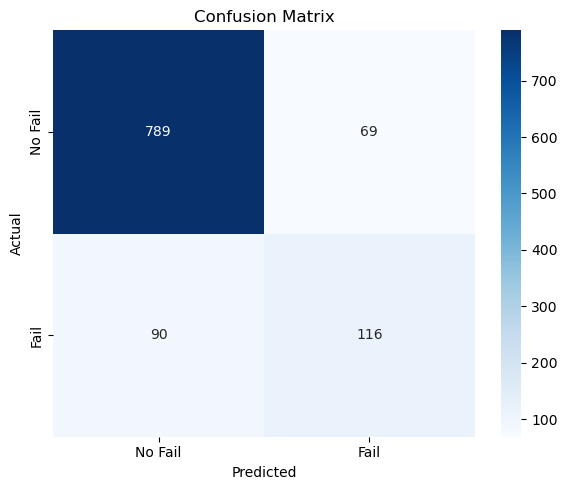

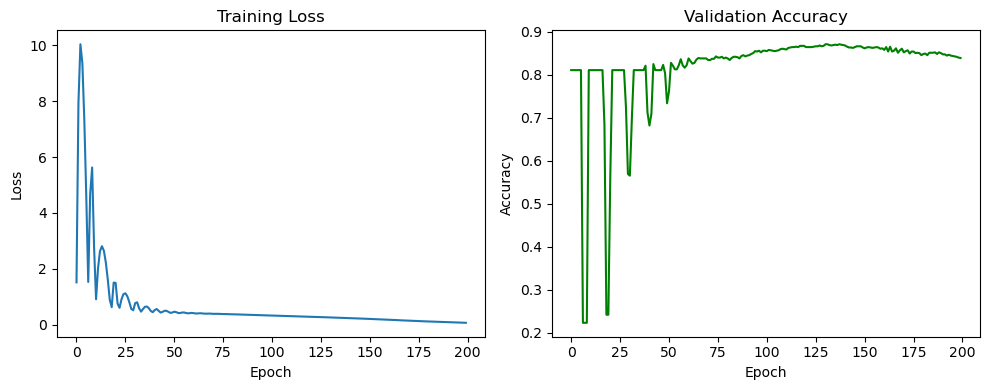

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 🔍 Evaluate on test set
model.eval()
with torch.no_grad():
    test_out = model(X_seq_test, graph_data.x, graph_data.edge_index, test_idx)
    y_pred = test_out.argmax(dim=1).cpu().numpy()
    y_true = y_test.cpu().numpy()
    y_prob = F.softmax(test_out, dim=1)[:, 1].cpu().numpy()

# 🧾 Metrics
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, digits=4)
roc_auc = roc_auc_score(y_true, y_prob)

print("📋 Classification Report:\n", report)
print(f"🔥 ROC AUC Score: {roc_auc:.4f}")

# 📊 Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fail", "Fail"], yticklabels=["No Fail", "Fail"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("visualization/hybrid_confusion_matrix.png", dpi=300)
plt.show()

# 📈 Training loss & validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Accuracy", color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.savefig("visualization/hybrid_training_curves.png", dpi=300)
plt.show()


In [8]:
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.explain.config import ModelConfig, ExplanationType, MaskType, NodeMaskType
import matplotlib.pyplot as plt

# GCN-only wrapper
class GCNOnlyModel(torch.nn.Module):
    def __init__(self, gcn1, gcn2):
        super().__init__()
        self.gcn1 = gcn1
        self.gcn2 = gcn2
    def forward(self, x, edge_index):
        x = F.relu(self.gcn1(x, edge_index))
        x = self.gcn2(x, edge_index)
        return F.log_softmax(x, dim=1)

gcn_model = GCNOnlyModel(model.gcn1, model.gcn2)

# Define explainer
explainer = Explainer(
    model=gcn_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type=ExplanationType.model,
    model_config=ModelConfig(
        mode='classification',
        task_level='node',
        return_type='log_prob'
    ),
    node_mask_type=NodeMaskType.attributes,
    edge_mask_type=MaskType.object
)

# Pick a test node
node_to_explain = test_idx[0].item()

# Run explanation
explanation = explainer(
    x=graph_data.x,
    edge_index=graph_data.edge_index,
    index=node_to_explain
)

# Visualize
ax = explanation.visualize_graph()
plt.title(f"GNNExplainer - Node {node_to_explain}")
save_path = f"visualization/gnn_explainer_node_{node_to_explain}.png"
plt.savefig(save_path, dpi=300)
plt.show()


ImportError: cannot import name 'NodeMaskType' from 'torch_geometric.explain.config' (c:\Users\binwa\anaconda3\Lib\site-packages\torch_geometric\explain\config.py)